In [358]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import *
from patsy import dmatrices
import itertools

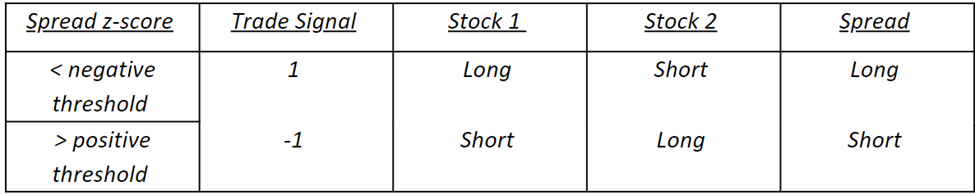


In [359]:
class PairsTrade:
    '''Class for Backtesting a Pairs Trading strategy using the cointegration method of pair creation with speed of adjustment filtering'''

    def __init__(self, start, end, formation_period, trading_period, filter, sd_threshold): # Constructor Method
        
        self.start = start
        self.end = end
        self.formation_period = slice(*formation_period)
        self.trading_period = slice(*trading_period)
        self.filter = filter
        self.threshold = sd_threshold
        self.get_data()
        self.get_close_prices()
        self.clean_data()  
        self.intorder()
        self.normalize_price_series()
        self.cointegration_testing()
        self.speedfiltering()
        self.generate_spreads()
        self.formation_analysed= self.calculate_spread_analysis(self.formation_spread_df)
        self.trading_analysed = self.calculate_spread_analysis(self.trading_spread_df)
        self.generate_signals()
        self.run_pairs_trading_strategy()
        
    def get_data(self):

        self.table = pd.read_html('https://en.wikipedia.org/wiki/FTSE_100_Index')[4]
        self.tickers_raw = self.table.iloc[:,1]
        self.tickers_Series = self.tickers_raw + ".L"
        self.tickers = self.tickers_Series.tolist()
        self.data = yf.download(self.tickers, start = self.start, end = self.end)
        if self.data.empty:
            print(f'No Data pulled for period {self.start} : {self.end}')

        else:
            swapped_columnindex = self.data.columns.swaplevel(0,1)
            data_copy = self.data.copy()
            data_copy.columns = swapped_columnindex
            data_copy = data_copy.sort_index(axis = 1, level = 0)
            self.data = data_copy
            self.data.columns = self.data.columns.set_levels(self.data.columns.levels[0].str.replace('.L', "", regex = False), level = 0)
            print("Data successfully retrieved")
            print('=' * 55)

    def plot_stock(self,symbol, cols=None):
        self.symbol = symbol
        if cols is None:
            cols = "Close"
        self.data.xs(symbol, level = 0, axis = 1)[cols].plot(figsize = (10,6), title = (f'A Graph of {self.symbol} {cols} Prices'))

    def get_close_prices(self):
        self.df = self.data.xs('Close', level=1, axis=1)

    
    def get_date_price(self,bar,symbol):
        rawdate = pd.to_datetime(bar)
        if rawdate in self.df.index:
            price = self.df.loc[rawdate, symbol]
            return str(rawdate.date()), price
        else:
            print(f"Date {rawdate} not found in data.")

    def clean_data(self):
        initial_column_count = self.df.shape[1]
        self.df_cleaned = self.df.dropna(axis=1, how = 'any')
        dropped_columns_count = initial_column_count - self.df_cleaned.shape[1]
        print(f"Number of columns dropped during cleaning for stationarity testing: {dropped_columns_count}")
        total_nans_cleaned = self.df_cleaned.isna().sum().sum()
        print(f"Total Number of NANs in the entire DataFrame after column removal: {total_nans_cleaned}")
        self.df = self.df_cleaned

    # Order of Integration Testing

    def intorder(self):
        def adf_test(series):
            result = sm.tsa.stattools.adfuller(series, autolag = 'BIC')
            return result[1]
        self.adfp = self.df.apply(adf_test, axis = 0) > 0.05
        diff_series = self.df.loc[:, self.adfp].diff().dropna()
        self.adfp2 = diff_series.apply(adf_test, axis = 0) > 0.05
        adfp2_alligned = self.adfp2.reindex(self.df.columns, fill_value = True)
        self.i1_prices = self.df.loc[:, ~adfp2_alligned]
        print(f" {len(self.i1_prices.columns)} I(1) Stocks")
        print("=" * 55)


    def normalize_price_series(self):
        self.norm_i1prices = self.i1_prices/ self.i1_prices.iloc[0]

    # Cointegration testing

    def cointegration_testing(self):
        self.formation_prices = self.norm_i1prices[self.formation_period]
        self.trading_prices = self.norm_i1prices[self.trading_period]

        self.stock_combinations = list(itertools.combinations(self.norm_i1prices.columns, 2))
        self.cointegrated_pairs = []
        self.cointegration_results = {
            'Stock 1': [],
            'Stock 2': [],
            'Alpha': [],
            'Average Alpha' : [],
            'Beta': [],
            'Constant' : []
        }
        for stock1 , stock2 in self.stock_combinations:

            Pairs_close = self.formation_prices[[stock1, stock2]]
            Pairs_close = Pairs_close.asfreq('B').ffill()

            #lag selection 
            var_model = sm.tsa.VAR(Pairs_close)
            lag_selection = var_model.select_order(maxlags = 15, trend = 'c')
            optimal_lag = lag_selection.bic        
            # Serial autocorrelation test - issue need to return
            #self.residuals = self.var_result.resid
            #out = sm.stats.stattools.durbin_watson(var_model.resid)
            #print(out) 

            coint_johansen_result = coint_johansen(Pairs_close, 0, optimal_lag)
            trace_stat = coint_johansen_result.lr1
            trace_critical_value = coint_johansen_result.cvt
           
            if trace_stat[0] > trace_critical_value[1,2]:
                print(f"For Stock Pair {stock1}, {stock2}:")
                print(f"Trace Statistic: {trace_stat}")
                print(f"Trace Statistic Critical Values (10%, 5%, 1%):\n{trace_critical_value}")
                print(f"Stock Pair {stock1}, {stock2} is cointegrated")
                print("=" * 55)
                self.cointegrated_pairs.append((stock1, stock2))

                model = VECM(Pairs_close, deterministic = 'ci', seasons = 0, k_ar_diff= optimal_lag , coint_rank= 1) # rank n.b
                vecm_result= model.fit()
                                       
                self.cointegration_results['Stock 1'].append(stock1)
                self.cointegration_results['Stock 2'].append(stock2)
                self.cointegration_results['Alpha'].append(vecm_result.alpha)
                self.cointegration_results['Average Alpha'] =  [(abs(alpha[0]) + abs(alpha[1])) / 2 for alpha in self.cointegration_results['Alpha']] # magnitude
                self.cointegration_results['Beta'].append(vecm_result.beta)
                self.cointegration_results['Constant'].append(vecm_result.const_coint)
                
        self.cointegration_df = pd.DataFrame(self.cointegration_results)
        self.cointegrated_pairs = self.cointegration_df.iloc[:, :2]
        
        print(f"Out of {len(self.stock_combinations)}  possible pairs there are {len(self.cointegration_df)} cointegrated pairs")


    def speedfiltering(self):
        self.filtered_pairs = self.cointegration_df[self.cointegration_df['Average Alpha'] > self.filter]
        print(f"Out of {len(self.cointegration_df)} Cointegrated Pairs there are {len(self.filtered_pairs)} Pairs with a Speed of Adjustment Coefficient greater than {self.filter}.")
        

    def generate_spreads(self):

        self.formation_spread_df = pd.DataFrame(index = self.formation_prices.index)
        self.trading_spread_df = pd.DataFrame(index = self.trading_prices.index)
        
        
        stocks1 = self.filtered_pairs['Stock 1'].values
        stocks2 = self.filtered_pairs['Stock 2'].values
        betas = self.filtered_pairs['Beta'].values
        constants = self.filtered_pairs['Constant'].values

        def calculate_spreads(prices, spread_df):
            for i in range(len(stocks1)):
                beta1, beta2 = betas[i]
                constant_value = constants[i][0][0]
                prices1 = prices.loc[:, stocks1[i]]
                prices2 = prices.loc[:, stocks2[i]]

                spread = constant_value + (prices1 * beta1) + (prices2 * beta2)
                spread_df[f"{stocks1[i]} - {stocks2[i]}"] = spread

        calculate_spreads(self.formation_prices, self.formation_spread_df)
        calculate_spreads(self.trading_prices, self.trading_spread_df)
    

    def calculate_spread_analysis(self, spread_df):
        pairs = spread_df.columns
        mean_spreads= np.mean(spread_df, axis=0)
        std_spreads = np.std(spread_df, axis = 0)
        spread_analysis = pd.DataFrame({
            'Pair' : pairs,
            'Mean_of_spread' : mean_spreads,
            'SD_spread': std_spreads})        
        return spread_analysis

    def generate_signals(self):
        threshold = self.threshold
        pair_names = self.trading_spread_df.columns
        columns = pd.MultiIndex.from_product([pair_names, ['Spread', 'Signal']], names=['Pair', 'Metric'])
        self.signals_df = pd.DataFrame(index= self.trading_spread_df.index, columns= columns)

        for pair in self.trading_spread_df.columns:
            mean_spread = self.formation_analysed.loc[pair, 'Mean_of_spread']
            std_spread = self.formation_analysed.loc[pair, 'SD_spread']

            upper_threshold = mean_spread + (std_spread * threshold)
            lower_threshold = mean_spread - (std_spread * threshold)

            spread = self.trading_spread_df[pair]
            self.signals_df[(pair,'Spread')] = spread

            conditions = [
                self.trading_spread_df[pair] > upper_threshold, #short
                self.trading_spread_df[pair] < lower_threshold, #long
                ]
            choices = [1,-1]
            default = 0
            self.signals_df[(pair,'Signal')] = np.select(conditions, choices, default=default)
            

    def print_balance(self, bar):
        '''Print out Current Cash Balance info'''
        date, price = self.get_date_price(bar)
        print(f'{date} | Current Balance: {self.amount:.2f}')

    def print_net_wealth(self, bar):
        '''Print out current net wealth info (current balance plus value of trading positions)'''
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | Current Net Wealth: {net_wealth:.2f}')

    # Core Methods
    def place_buy_order(self, bar, stock, units=None, amount = None):
        '''Place a Buy order for a specific stock'''
        date, price = self.get_date_price(bar, stock)
        if units is None:
            units = int(amount/price) if amount else 0
        total_cost = (units*price) * (1 + self.ptc) + self.ftc
        self.amount -= total_cost
        self.units += units
        self.position = 1
        self.trades += 1
        
        self.data.loc[bar, 'Inventory'] = self.units
        self.data.loc[bar, 'position'] = self.position        
        if self.verbose:
            print(f'{date} | Buying {units} of {stock} at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
            print('=' * 55)

    def place_sell_order(self, bar, stock, units=None, amount = None):
        '''Place a Sell order'''
        date, price = self.get_date_price(bar, stock)
        if units is None:
            units = int(amount/price) if amount else 0 
        total_revenue = (units*price) * (1 - self.ptc) - self.ftc
        self.amount += total_revenue
        self.units -= units
        self.position = 0 if self.units <= 0 else 1
        self.trades += 1
        self.data.loc[bar, 'Inventory'] = self.units
        self.data.loc[bar, 'position'] = self.position
        if self.verbose:
            print(f'{date} | Selling {units} of {stock} at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
            print('=' * 55)
    
    # def close_out(self, bar):
    #     '''Closing out positions at the end of the backtest period'''
    #     date, price = self.get_date_price(bar)
    #     self.amount += self.units * price
    #     self.units = self.units
    #     if self.verbose:
    #         print(f'{date} | inventory {self.units} units at {price:.2f}')
    #         print('=' * 55)
    #         print('Final balance [$] {:.2f}'.format(self.amount))
    #         perf = ((self.amount - self.initial_amount) /
    #                 self.initial_amount * 100)
    #         print('Net Performance [%] {:.2f}'.format(perf))
    #         print('Trades executed [#] {:.2f}'.format(self.trades))
    #         print('=' * 55)    

    def go_long(self, bar, stock1, stock2, units=None, amount=None):
        '''Execute a long position on stock1 and short position on stock2.'''
        # if self.position == -1:
        #         self.place_buy_order(bar, stock2, units=self.units)
        if units:
                self.place_buy_order(bar, stock = stock1, units=units)
                self.place_sell_order(bar, stock=stock2, units=units)
        elif amount:
            if amount == 'all':
                    amount = self.amount
            self.place_buy_order(bar, stock1, amount=amount)   
            self.place_sell_order(bar, stock2, amount=amount)

    def go_short(self, bar, stock1, stock2, units=None, amount=None):
        '''Execute a short position on stock1 and long position on stock2'''
        if self.position == 1:
                self.place_sell_order(bar, stock1, units=self.units)
        if units:
                self.place_sell_order(bar,stock1, units=units)
                self.place_buy_order(bar,stock2, units=units)
        elif amount:
            if amount == 'all':
                    amount = self.amount
            self.place_sell_order(bar,stock1, amount=amount)
            self.place_buy_order(bar,stock2, amount =amount)
       

    def run_pairs_trading_strategy(self):
        self.computated_df = self.signals_df.copy()
        signal_change = self.signals_df.xs('Signal', axis = 1, level =1).diff()
        self.computated_df[(slice(None), 'Signal Change')] = signal_change
        
        metrics = ['Position', 'Realised Return', 'Equity', 'Inventory']
        pairs = self.signals_df.columns.get_level_values(0).unique()

        def initialize_trading_variables(self):
            self.position = 0
            self.units = 0
            self.amount = self.initial_amount
            self.buy_price = None


        def execute_trading_logic(self, bar, pair, spreads, signals, stock1_prices, stock2_prices):
            signal_change = signals.loc[bar]

            if signal_change == -1 and self.position == 0:
                self.go_long(bar, stock1, stock2, amount = 1)
            elif signal_change == -1 and self.position == 1:
                self.go_short(bar, stock1, stock2, amount = 1)

            for pair in pairs: 
                for metric in metrics:
                    self.computated_df[(pair, metric)] = np.nan

        for pair in pairs:
            self.initialize_trading_variables()
            spreads = self.signals_df[(pair, 'Spread')]
            signals = self.computated_df['Signal Change']
            stock1, stock2 = [x.strip() for x in pairs.split("-")]
            stock1_prices = self.trading_prices[stock1]
            stock2_prices = self.trading_prieces[stock2]

            for bar in self.computed_df.index:
                self.execute_trading_logic(bar, pair, spreads, signals, stock1_prices, stock2_prices)

            self.close_out(bar)

        self.computated_df.loc[:, (slice(None), 'Inventory')] = self.computated_df.loc[:, (slice(None), 'Inventory')].ffill()


In [ ]:
self = PairsTrade(start = "2022-01-01", end = "2023-12-25", formation_period=("2022-01-01", "2023-01-01"), trading_period=("2023-01-01", "2023-12-25"), filter = 0.1 , sd_threshold = 1)

In [345]:
# Application of Cholesky decomposition from Oxford Online Lectures out of interest

A = np.array([[4,2,14],[2,17,-5],[14,-5,83]])
x = np.array([["x"],
              ["y"],
              ["z"]])
b = np.array([[20],[14],[92]])

In [ ]:
L = np.linalg.cholesky(A)
A

In [ ]:
z = np.linalg.solve(L,b)
z

In [ ]:
x = np.linalg.solve(L.T, z)
print(L)
print(L.T)
x

In [ ]:
V = np.array([[4,2,4,0], [2,2,3,2],[4,2,6,3],[0,2,3,9]])
V

In [ ]:
np.linalg.cholesky(V)

Status:
- Data has been correctly cleaned and organised for Cointegration testing
- Cointegratin tests have been successfully performed on the formation period allowing for filtering of cointegrated pairs
- Speed of Adjustment coefficients have been extracted correctly, allowing for speed filtering.
- Trade signals have been created correctly based on the standard deviation of the spread between cointegrated stocks.
- The issue lies with running the trading strategy and attempting to back test and compute returns. Issues began from the use of backtesting base class core methods of 'Place Buy order' and 'Place sell order' which have been taken from Python for Algorithmic Trading by Yves Hilpisch. I have tried to modify the use of these methods for the duel legged pairs trading strategy, to maintain general practice. However, the code has many logic and syntax errors. I will revisit the code once I have developed a greater fluency in Python back testing.

